In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import xgboost
from math import sqrt
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import gradient_descent_v2
# from tensorflow.keras.optimizers import SGD
from keras import activations
from sklearn.metrics import r2_score
import datetime
import os
import seaborn as sns

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data);
	# print(df);
	cols, names = list(), list();
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i));
		names += [(f'var{j+1}(t-{i})') for j in range(n_vars)];
	# forecast sequence (t, t+1, ... t+n)
	df = df[10]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names.append(f'var1(t)')
			# names += [(f'var{j+1}(t)') for j in range(n_vars)]
		else:
			names.append(f'var1(t+{i})')
			# names += [(f'var{j+1}(t+{i})') for j in range(n_vars)];
	# put it all together
	agg = pd.concat(cols, axis=1);
	print(names)
	agg.columns = names;

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
df_merged_initial = pd.read_csv('/content/drive/MyDrive/btc_tweet_sentiment/btc-sent-f4.csv')

df_merged_initial.time = pd.to_datetime(df_merged_initial.time)

In [5]:
df_merged_initial.isnull().values.any()

False

In [6]:
df_merged_initial[df_merged_initial.index.duplicated]

,time,compound,neg,pos,weighted_comp,weighted_neg,weighted_pos,count,open


In [7]:
df_merged_initial = df_merged_initial.set_index('time')
df_merged_initial = df_merged_initial.sort_index()

In [9]:
pd.date_range(start = '2021-11-30 02:00:00+00:00', end = '2022-05-30 01:00:00+00:00', freq='1h' ).difference(df_merged_initial.index)

DatetimeIndex([], dtype='datetime64[ns, UTC]', freq=None)

In [10]:
df_merged_initial = df_merged_initial.astype('float')

In [11]:
df_merged_initial

,compound,neg,pos,weighted_comp,weighted_neg,weighted_pos,count,open
time,,,,,,,,
2021-11-30 02:00:00+00:00,0.238187,0.041932,0.129963,0.593775,0.535233,0.584588,1920.0,57342.23
2021-11-30 03:00:00+00:00,0.195387,0.047686,0.118205,0.581798,0.533827,0.574934,1895.0,57422.98
2021-11-30 04:00:00+00:00,0.229451,0.043506,0.122816,0.604458,0.529832,0.580733,1858.0,57149.33
2021-11-30 05:00:00+00:00,0.180722,0.053008,0.118401,0.578368,0.534701,0.574109,2036.0,57258.68
2021-11-30 06:00:00+00:00,0.210184,0.049462,0.125099,0.584154,0.530428,0.571678,2266.0,56300.00
...,...,...,...,...,...,...,...,...
2022-06-06 19:00:00+00:00,0.141527,0.058153,0.113233,0.561899,0.537099,0.570748,2338.0,31328.19
2022-06-06 20:00:00+00:00,0.103024,0.064454,0.106370,0.550823,0.537045,0.566685,2346.0,31451.46
2022-06-06 21:00:00+00:00,0.136252,0.054313,0.111042,0.562962,0.534756,0.569828,2028.0,31434.53


In [12]:
# df_tr = df_merged_initial.drop(["count",], axis=1)
df_tr = df_merged_initial.drop(["count",'compound', 'neg', 'weighted_neg', 'weighted_comp', 'weighted_pos', 'pos',], axis=1)

df_tr["month"] = df_tr.index.month
df_tr["day_of_week"] = df_tr.index.day_of_week
df_tr["day_of_month"] = df_tr.index.day
# dict_days = {0:"1_Mon", 1:"2_Tue", 2:"3_Wed", 3:"4_Thu", 4:"5_Fri", 5:"6_Sat", 6:"7_Sun"}
# df_tr["weekday"] = df_tr["wday"].apply(lambda x: dict_days[x])


df_tr["hour"] = df_tr.index.hour

df_tr = df_tr.astype({"hour":"category", "day_of_week":"category", "day_of_month": "category", "month": "category"})

In [ ]:
# df_tr = df_tr[['month', 'day_of_month', 'day_of_week', 'hour', 'open']]
df_tr = df_tr[['compound', 'neg', 'weighted_neg', 'weighted_comp', 'weighted_pos', 'pos', 'month', 'day_of_month', 'day_of_week', 'hour', 'open']]

In [ ]:
values = df_tr.values

In [ ]:
values = values.astype('float32')

In [ ]:
values

array([[2.3035483e-01, 4.4723179e-02, 5.2190965e-01, ..., 1.0000000e+00,
        1.0000000e+00, 5.7771852e+04],
       [2.3818651e-01, 4.1931771e-02, 5.2635384e-01, ..., 1.0000000e+00,
        2.0000000e+00, 5.7342230e+04],
       [1.9538660e-01, 4.7686014e-02, 5.2357107e-01, ..., 1.0000000e+00,
        3.0000000e+00, 5.7422980e+04],
       ...,
       [1.5088107e-01, 5.4451615e-02, 5.2909005e-01, ..., 1.0000000e+00,
        2.2000000e+01, 3.1691510e+04],
       [1.3699751e-01, 6.3979253e-02, 5.3097647e-01, ..., 1.0000000e+00,
        2.3000000e+01, 3.1852551e+04],
       [1.2930322e-01, 7.0754386e-02, 5.3009671e-01, ..., 2.0000000e+00,
        0.0000000e+00, 3.1784180e+04]], dtype=float32)

In [ ]:
n_hours = 6
n_features = 11
n_future_hours = 1
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, n_future_hours)

['var1(t-6)', 'var2(t-6)', 'var3(t-6)', 'var4(t-6)', 'var5(t-6)', 'var6(t-6)', 'var7(t-6)', 'var8(t-6)', 'var9(t-6)', 'var10(t-6)', 'var11(t-6)', 'var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)', 'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)', 'var11(t-5)', 'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)', 'var10(t-4)', 'var11(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var1(t)']


In [ ]:
values = reframed.values
n_train_hours =  3514
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [ ]:
test_hours = df_merged_initial.index[n_train_hours:]
test_hours = test_hours[n_hours:]

In [ ]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_future_hours:]
test_X, test_y = test[:, :n_obs], test[:, -n_future_hours:]
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(3514, 66) (872, 66) (3514, 1) (872, 1)


In [ ]:
# train_y, test_y = train_y.reshape(len(train_y)), test_y.reshape(len(test_y))

In [ ]:
train_y

array([[56597.34],
       [56563.65],
       [56820.56],
       ...,
       [38735.97],
       [39063.61],
       [38978.65]], dtype=float32)

In [ ]:
x_scaler = MinMaxScaler()
train_X_scaled = x_scaler.fit_transform(train_X)
test_X_scaled = x_scaler.transform(test_X)

y_scaler = MinMaxScaler()
train_y_scaled = y_scaler.fit_transform(train_y)
test_y_scaled = y_scaler.transform(test_y)


In [ ]:
train_y_scaled = train_y_scaled.reshape(len(train_y_scaled))

In [ ]:
train_y_scaled

array([0.91909194, 0.917773  , 0.927829  , ..., 0.21996737, 0.23279178,
       0.22946632], dtype=float32)

In [ ]:
train_X = train_X_scaled.reshape((train_X_scaled.shape[0], n_hours, n_features))
test_X = test_X_scaled.reshape((test_X_scaled.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3514, 6, 11) (3514, 2) (871, 6, 11) (871, 2)


In [ ]:
train_X = train_X_scaled
test_X = test_X_scaled

In [ ]:
train_y = train_y_scaled
test_y = test_y_scaled

In [ ]:
reg = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000, nthread=24)
reg.fit(train_X, train_y)

XGBRegressor(n_estimators=1000, nthread=24, objective='reg:squarederror')

In [ ]:
model = Sequential()
model.add(LSTM(256, activation=activations.relu, input_shape=(n_hours, n_features), return_sequences=True))
model.add(LSTM(128, activation=activations.relu, return_sequences=True))
model.add(LSTM(64, activation=activations.relu, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(n_future_hours))

In [ ]:
opt = gradient_descent_v2.SGD(learning_rate=0.1, momentum=0.8)
model.compile(loss='mae', optimizer=opt, metrics=['mse'])

checkpoint_path = "new_data_model3_xg_only_price.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [checkpoint, earlystopping]
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 6, 256)            268288    
                                                                 
 lstm_34 (LSTM)              (None, 6, 128)            197120    
                                                                 
 lstm_35 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 514,946
Trainable params: 514,946
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_X, train_y, batch_size=4, epochs=60, validation_split=0.1, verbose=1, callbacks=callbacks)

Epoch 1/60
790/791 [============================>.] - ETA: 0s - loss: 0.0851 - mse: 0.0135
Epoch 1: val_loss improved from inf to 0.20977, saving model to new_data_model3_xg_only_price.hdf5
791/791 [==============================] - 26s 28ms/step - loss: 0.0852 - mse: 0.0136 - val_loss: 0.2098 - val_mse: 0.0464
Epoch 2/60
790/791 [============================>.] - ETA: 0s - loss: 0.0567 - mse: 0.0053
Epoch 2: val_loss improved from 0.20977 to 0.04185, saving model to new_data_model3_xg_only_price.hdf5
791/791 [==============================] - 22s 27ms/step - loss: 0.0567 - mse: 0.0053 - val_loss: 0.0419 - val_mse: 0.0021
Epoch 3/60
791/791 [==============================] - ETA: 0s - loss: 0.0547 - mse: 0.0049
Epoch 3: val_loss improved from 0.04185 to 0.03169, saving model to new_data_model3_xg_only_price.hdf5
791/791 [==============================] - 21s 27ms/step - loss: 0.0547 - mse: 0.0049 - val_loss: 0.0317 - val_mse: 0.0014
Epoch 4/60
790/791 [============================>.] -

yaha model load karwa le drive se new_data_model1.hdf5

In [ ]:
results = model.evaluate(test_X, test_y)
print(results)

28/28 [==============================] - 1s 13ms/step - loss: 0.1255 - mse: 0.0229
[0.12552034854888916, 0.022888995707035065]


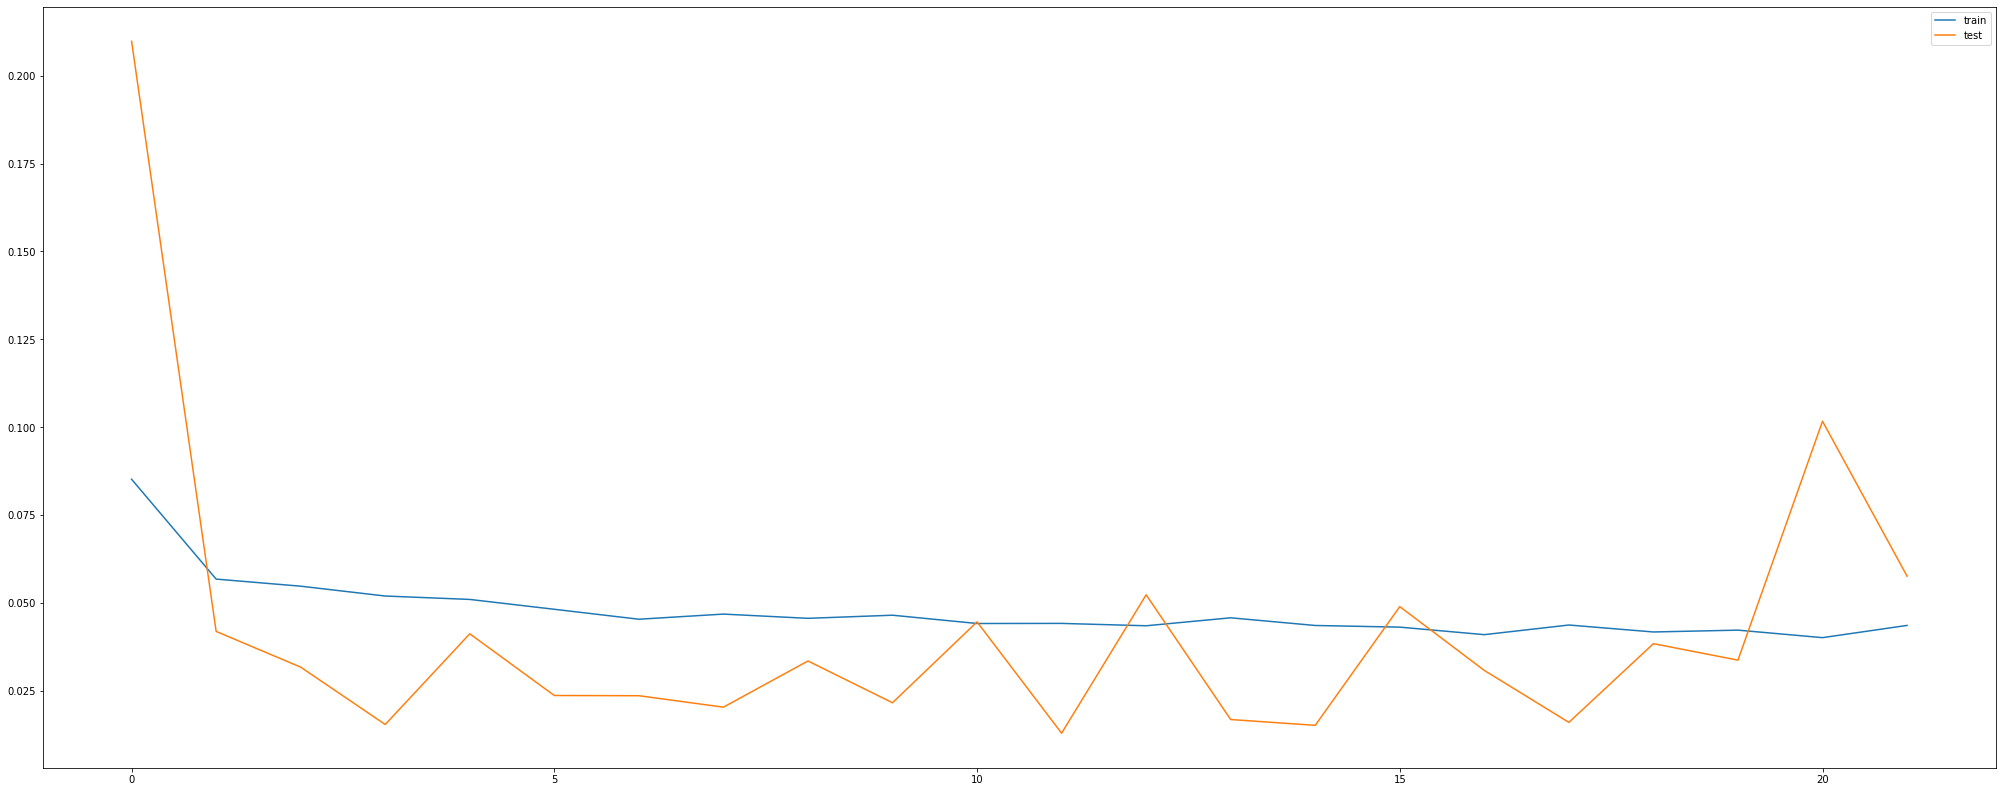

In [ ]:

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = reg.predict(test_X)
yhat = yhat.reshape(len(yhat), 1)

In [ ]:
yhat = model.predict(test_X)
# invert scaling for forecast

In [ ]:
actual = y_scaler.inverse_transform(test_y.reshape(len(test_y), 1))

In [ ]:
predicted = y_scaler.inverse_transform(yhat)

In [ ]:
reg.save_model("new_data_model4_xgb_legit_only_price.hdf5")

In [ ]:
import plotly.express as px


df_res = pd.DataFrame()

df_res['actual'] = [x[0] for x in actual[:24*15, 0:1]]
df_res['predicted'] = [x[0] for x in predicted[:24*15, 0:1]]
df_res['date'] = [x for x in test_hours[:24*15]]


fig = px.line(df_res, x="date", y=['actual','predicted'],
              hover_data={"date": "|%B %d, %Y"},
              title='Transformer Multivariate with sentiments')

fig.show()

ye neche wali values use karlio plot ke lie

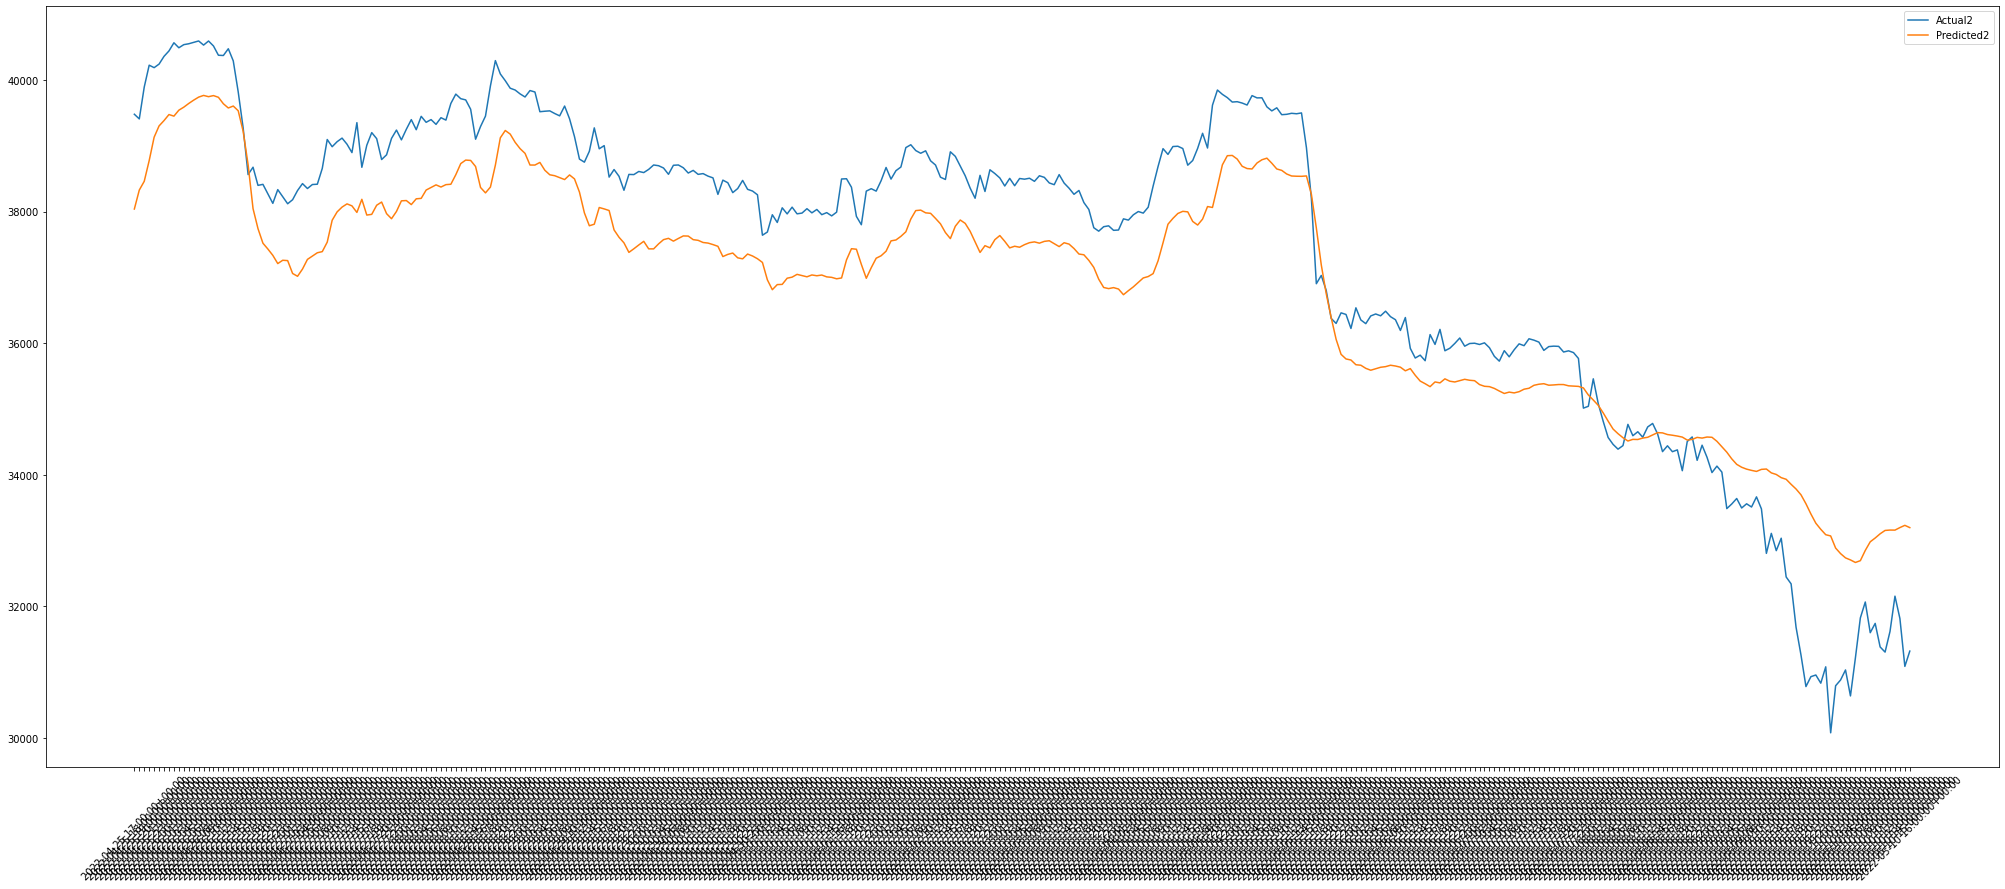

In [ ]:
pyplot.figure()
pyplot.rcParams["figure.figsize"] = (35,14)
# pyplot.plot(np.array(inv_y_comb)[:24*10, :1], label='Actual1')
# pyplot.plot(np.array(inv_yhat_comb)[:24*10, :1], label='Predicted1')
pyplot.plot(actual[:24*15, 0:1], label='Actual2')
pyplot.plot(predicted[:24*15, 0:1], label='Predicted2')
default_x_ticks = range(len(test_hours[:24*15]))
pyplot.xticks((default_x_ticks), test_hours[:24*15], rotation=45)
# pyplot.plot_date(test_hours[:24*15], actual[:24*15, 0:1], fmt='d')
pyplot.legend()
pyplot.show()

In [ ]:
import plotly.express as px

df = px.data.stocks()
fig = px.line(df, x='date', y="GOOG")
fig.show()

In [ ]:
rmse = sqrt(mean_squared_error(actual, predicted))
print('Test RMSE: %.3f' % rmse)
rmse_percent = (rmse/actual.mean()) * 100
print(f"rmse in percentage = {rmse_percent}")

Test RMSE: 3505.534
rmse in percentage = 10.651696497480883


In [ ]:
# results = model.evaluate(test_X, test_y)
# print(results)
# rmse = sqrt(mean_squared_error(inv_y_comb, inv_yhat_comb))
# print('Test RMSE: %.3f' % rmse)
# rmse_percent = (rmse/inv_y_comb.mean()) * 100
# print(f"rmse in percentage = {rmse_percent}")

'results = model.evaluate(test_X, test_y)\nprint(results)\nrmse = sqrt(mean_squared_error(inv_y_comb, inv_yhat_comb))\nprint(\'Test RMSE: %.3f\' % rmse)\n# rmse_percent = (rmse/inv_y_comb.mean()) * 100\n# print(f"rmse in percentage = {rmse_percent}")'

In [ ]:
"""# batch size 4 epochs 20, observed_hours=2
results = model.evaluate(test_X, test_y)
print(results)


pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
# invert scaling for forecast
inv_yhat = np.repeat(yhat, 6,axis=-1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,5]

test_y_reshaped = test_y.reshape(len(test_y),1)
inv_y = np.repeat(test_y_reshaped, 6,axis=-1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,5]


pyplot.rcParams["figure.figsize"] = (50,12)
pyplot.plot(inv_y[:24*10], label='Actual')
pyplot.plot(inv_yhat[:24*10], label='Predicted')
default_x_ticks = range(len(test_hours[:24*10]))
pyplot.xticks(default_x_ticks, test_hours[:24*10], rotation=90)
pyplot.legend()
pyplot.show()


rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
rmse_percent = (rmse/inv_y.mean()) * 100
print(f"rmse in percentage = {rmse_percent}")"""

'# batch size 4 epochs 20, observed_hours=2\nresults = model.evaluate(test_X, test_y)\nprint(results)\n\n\npyplot.plot(history.history[\'loss\'], label=\'train\')\npyplot.plot(history.history[\'val_loss\'], label=\'test\')\npyplot.legend()\npyplot.show()\n\n\nyhat = model.predict(test_X)\n# invert scaling for forecast\ninv_yhat = np.repeat(yhat, 6,axis=-1)\ninv_yhat = scaler.inverse_transform(inv_yhat)\ninv_yhat = inv_yhat[:,5]\n\ntest_y_reshaped = test_y.reshape(len(test_y),1)\ninv_y = np.repeat(test_y_reshaped, 6,axis=-1)\ninv_y = scaler.inverse_transform(inv_y)\ninv_y = inv_y[:,5]\n\n\npyplot.rcParams["figure.figsize"] = (50,12)\npyplot.plot(inv_y[:24*10], label=\'Actual\')\npyplot.plot(inv_yhat[:24*10], label=\'Predicted\')\ndefault_x_ticks = range(len(test_hours[:24*10]))\npyplot.xticks(default_x_ticks, test_hours[:24*10], rotation=90)\npyplot.legend()\npyplot.show()\n\n\nrmse = sqrt(mean_squared_error(inv_y, inv_yhat))\nprint(\'Test RMSE: %.3f\' % rmse)\nrmse_percent = (rmse/inv_